# SynCom Abs-to-Cell_Count models

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

from os.path import join as pjoin

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Helper Functions

In [2]:
def get_regressorand(df, regressorand='560'):
    """
    The following function returns the values for the independant variable (i.e. regressor, X) OR
    the dependand variable (i.e. regressand, Y) for simple linear regression (Y ~ mX + b) models.
    These regressors are all wavelengths NOT in the following list [680, 720, 730, 750] as these 
    wavelengths serve as the regressands in the models to be constructed. These regressands are
    chosen specifically because the photobioreactor used in the lab collects data at 680 & 720 only
    AND, previously, experiements done in the Tecan reactor collected data in using 680, 730, 750 
    wavelenghts.
    
    For any specific wavelegnth the function returns a tuple where the first element contains the
    values of the 12 column of a 96 well plate as measure by the tecan: This 12th columns contains
    only bacteria. The second element in the tuple contains the values for the row H of a 96 well
    plate, this row contains only chlamy in its wells
    """
    # name of the column in the dataframe    
    dfcol = regressorand
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    col12= []
    for row in rows:
        col12.append(df.loc[(df['row']==row) & (df['col']==12), dfcol][0])
        
    rowH = []
    for col in cols:
        rowH.append(df.loc[(df['row']=='H') & (df['col']==col), dfcol][0])
    
    # measured values at 12th and H'th row respectively
    bacter, chlamy = np.array(col12), np.array(rowH)
    
    return bacter, chlamy
  




def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    
    fs = (8, 10)
    
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max())
    smx = smx+.1*smx
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8), ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx) 
    axes[0].set_ylim(bottom=-0.01, top=smx)



    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12), ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':9})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

    # get predicted values from column named
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Cp].max(), df['C'].max())
    smx = smx+.1*smx
    
    
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8), ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]_{pred}}$')
    axes[0].set_xlabel('$[C]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx)
    axes[0].set_ylim(bottom=-0.01, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12), ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':9}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]_{pred}}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("[Chlamy] Predictions Using Simple Linear Regression Models @"+column, y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    
    

# Data

In [3]:
path = '''../data_o/calibration/community_calibration/parsed_data'''

fname='community_calibration_w_cell_counts_df.csv'

In [4]:
mdf = pd.read_csv(pjoin(path,fname), index_col=0)

# Process

In [5]:
######################################
# correct values used for regression #
######################################
for col in [i for i in mdf.columns[4:].values if 'sdv' not in i]:
    #subtract 'blank' well values
    mdf.loc[:,col] = mdf.loc[:,col] - mdf.loc['H12',col]

In [8]:
mdf.head()

,row,col,B_lbl,C_lbl,B_cc,C_cc,A600,A600_sdv,A680,A680_sdv,...,660,670,680,690,700,710,720,730,740,750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,779407242.5,4446473.150,1.0938,0.0618,1.4928,0.0686,...,1.2798,1.4125,1.4652,1.2293,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032
A2,A,2,0.4,0.46,779407242.5,4081862.352,1.0292,0.0746,1.3929,0.0742,...,1.2044,1.3205,1.3658,1.1698,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660
A3,A,3,0.4,0.42,779407242.5,3717251.554,0.9685,0.0768,1.2995,0.0818,...,1.1188,1.2301,1.2734,1.0813,0.8680,0.7985,0.7672,0.7458,0.7334,0.7209
A4,A,4,0.4,0.38,779407242.5,3352640.755,0.9106,0.0732,1.2021,0.0791,...,1.0456,1.1440,1.1832,1.0131,0.8222,0.7584,0.7300,0.7094,0.6977,0.6858
A5,A,5,0.4,0.34,779407242.5,2988029.957,0.8852,0.0785,1.1458,0.0879,...,0.9979,1.0872,1.1227,0.9692,0.7939,0.7354,0.7079,0.6883,0.6763,0.6646


# a680 a720 to B

In [6]:
def get_B_or_C_values(df,  row_col='row', dfcol='C_cc'):
    """
    
    """
    # name of the column in the dataframe    
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    if row_col=='col':
        
        col12= []
        for row in rows:
            col12.append(df.loc[(df['row']==row) & (df['col']==12), dfcol][0])
            
        return np.array(col12)
    
    if row_col=='row':
        rowH = []
        for col in cols:
            rowH.append(df.loc[(df['row']=='H') & (df['col']==col), dfcol][0])
        
        return np.array(rowH)

def get_predictions(df, coefs, regressor='CC', first_regressand=None, second_regressand=None):
    """
    This function uses the coefficients obtained from the simple linear and Beer-Lambert's law
    to make predictions. Each prediction is composed of either the [bacterial] or [chlamy] 
    fraction of the regressor signal. Ensure that you're using the coefficient dictionary for 
    the proper regressand wavelengths. If you use wavelengths other than 'A680' and A720, 
    ensure that you type those in the predictions.
    """
    
    
    kB1, kC1, kB2, kC2 = coefs
    
    tdf = df.copy()

    yT1 = first_regressand
    yT2 = second_regressand
    
    
    tdf['B_p'+regressor] = (kC2*tdf[yT1] - kC1*tdf[yT2]) / (-kC1*kB2 + kC2*kB1)
    tdf['C_p'+regressor] = (kB2*tdf[yT1] - kB1*tdf[yT2]) / (-kB1*kC2 + kB2*kC1)
    
    
    return tdf[['B_p'+regressor, 'C_p'+regressor]].copy()

In [7]:
# since you already know the concentrations
# you just need to regress onto each one
xB = get_B_or_C_values(mdf,  row_col='col', dfcol='B_cc')
xC = get_B_or_C_values(mdf,  row_col='row', dfcol='C_cc')

# these are measured values found in the dataframe col12 values, rowH values
yB1, yC1 = get_regressorand(mdf, regressorand='A680') 
yB2, yC2 = get_regressorand(mdf, regressorand='A720')
    
lin_reg_objs = [LinearRegression() for i in range(4)]

kB1 = lin_reg_objs[0].fit(X=xB.reshape(-1,1), y=yB1)
kC1 = lin_reg_objs[1].fit(X=xC.reshape(-1,1), y=yC1)

kB2 = lin_reg_objs[2].fit(X=xB.reshape(-1,1), y=yB2)
kC2 = lin_reg_objs[3].fit(X=xC.reshape(-1,1), y=yC2)
    
kCC720 = [kB1.coef_[0], kC1.coef_[0], kB2.coef_[0], kC2.coef_[0]]

In [8]:
# since you already know the concentrations
# you just need to regress onto each one
xB = get_B_or_C_values(mdf,  row_col='col', dfcol='B_cc')
xC = get_B_or_C_values(mdf,  row_col='row', dfcol='C_cc')

# these are measured values found in the dataframe col12 values, rowH values
yB1, yC1 = get_regressorand(mdf, regressorand='A680') 
yB2, yC2 = get_regressorand(mdf, regressorand='730')
    
lin_reg_objs = [LinearRegression() for i in range(4)]

kB1 = lin_reg_objs[0].fit(X=xB.reshape(-1,1), y=yB1)
kC1 = lin_reg_objs[1].fit(X=xC.reshape(-1,1), y=yC1)

kB2 = lin_reg_objs[2].fit(X=xB.reshape(-1,1), y=yB2)
kC2 = lin_reg_objs[3].fit(X=xC.reshape(-1,1), y=yC2)
    
kCC730 = [kB1.coef_[0], kC1.coef_[0], kB2.coef_[0], kC2.coef_[0]]


In [9]:
# since you already know the concentrations
# you just need to regress onto each one
xB = get_B_or_C_values(mdf,  row_col='col', dfcol='B_cc')
xC = get_B_or_C_values(mdf,  row_col='row', dfcol='C_cc')

# these are measured values found in the dataframe col12 values, rowH values
yB1, yC1 = get_regressorand(mdf, regressorand='A680') 
yB2, yC2 = get_regressorand(mdf, regressorand='A750')
    
lin_reg_objs = [LinearRegression() for i in range(4)]

kB1 = lin_reg_objs[0].fit(X=xB.reshape(-1,1), y=yB1)
kC1 = lin_reg_objs[1].fit(X=xC.reshape(-1,1), y=yC1)

kB2 = lin_reg_objs[2].fit(X=xB.reshape(-1,1), y=yB2)
kC2 = lin_reg_objs[3].fit(X=xC.reshape(-1,1), y=yC2)
    
kCC750 = [kB1.coef_[0], kC1.coef_[0], kB2.coef_[0], kC2.coef_[0]]

In [10]:
kcc_models = {'kcc_720':kCC720, 'kcc_730':kCC730, 'kcc_750':kCC750}

cc_models = pd.DataFrame.from_dict(kcc_models, orient='index', columns=['kB680', 'kC680', 'kB7xx', 'kC7xx'])

In [11]:
path = '''../data_o/calibration/community_calibration/created_models'''
cc_models.to_csv(pjoin(path, 'cell_counter_slr_models.csv'))

In [12]:
tmp = get_predictions(mdf, coefs=ks, regressor='CC', first_regressand='A680', second_regressand='A720')

NameError: name 'ks' is not defined

In [13]:
pdf = pd.concat([mdf,tmp], axis=1)
pdf.head()

NameError: name 'tmp' is not defined

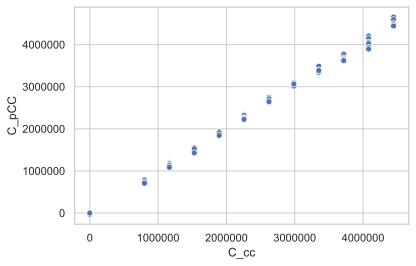

In [55]:
sns.scatterplot(data=pdf, x='C_cc', y='C_pCC')

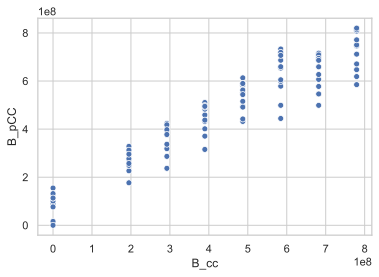

In [65]:
sns.scatterplot(data=pdf, x='B_cc', y='B_pCC')

In [57]:

# to get the error in the predictions you have to find the standard deviations of 
# the predictions themselves